In [21]:
import os
import sys

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import statsmodels.api as sm

from platypus.algorithms import EpsMOEA, NSGAIII, MOEAD
from ema_workbench.analysis import prim, cart, dimensional_stacking, parcoords
from ema_workbench import ema_logging, load_results, MultiprocessingEvaluator, Constraint, Scenario
from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench.em_framework.optimization import ArchiveLogger, EpsilonProgress, epsilon_nondominated, Convergence, rebuild_platypus_population


from ema_workbench import (
    HypervolumeMetric,
    GenerationalDistanceMetric,
    EpsilonIndicatorMetric,
    InvertedGenerationalDistanceMetric,
    SpacingMetric,
)

from ema_workbench.em_framework.optimization import to_problem

from SALib.analyze import sobol

from problem_formulation import get_model_for_problem_formulation

In [2]:
problem_formulation_id = 6
dike_model, planning_step = get_model_for_problem_formulation(problem_formulation_id)

uncertainties = [u.name for u in dike_model.uncertainties]
levers = [l.name for l in dike_model.levers]
ooi = [o.name for o in dike_model.outcomes]
ooi_dr3 = ['A.3_Expected Annual Damage', 'A.3_Expected Number of Deaths', 'A.3_Dike Investment Costs']

# General Analysis for OOI of Dike Ring 3
Goals
* Understand the OOI distribution
* Determine the thresholds for different OOI of Dike Ring 3

Steps
* Inspect the OOI distribution using: histogram and accumulative plots
* Identify threshold values for each OOI of Dike Ring 3

Results:
* From the general stats of the 3 OOI for Dike Ring 3, it can be seen that A.3_Dike Investment Costs is 0 since there is no policy applied to these experiments. The general analysis of the OOI will focus on **A.3_Expected Annual Damage** and **A.3_Expected Number of Deaths**
* The plots of the distributions of the OOI shows that for the status quo (i.e: no policy), the **A.3_Expected Annual Damage** and **A.3_Expected Number of Deaths** are relatively low for more than half of the time. The threshold for worse-case scenarios for these 2 OOIs are taken as the 90th value.

In [3]:
experiment, outcomes = load_results(os.path.join('experiment', 'pol0_sc500.tar.gz'))
df_outcomes = pd.DataFrame(outcomes)

In [4]:
df_outcomes.describe()

,A.3_Expected Annual Damage,A.3_Dike Investment Costs,A.3_Expected Number of Deaths
count,2.000000e+04,20000.0,20000.000000
mean,3.989421e+08,0.0,0.695917
std,6.419060e+08,0.0,1.094826
min,0.000000e+00,0.0,0.000000
25%,0.000000e+00,0.0,0.000000
50%,3.177951e+07,0.0,0.063880
75%,5.374712e+08,0.0,0.955720
max,2.527031e+09,0.0,3.216259


From the general stats of the 3 OOI for Dike Ring 3, it can be seen that A.3_Dike Investment Costs is 0 since there is no policy applied to these experiments. The general analysis of the OOI will focus on **A.3_Expected Annual Damage** and **A.3_Expected Number of Deaths**

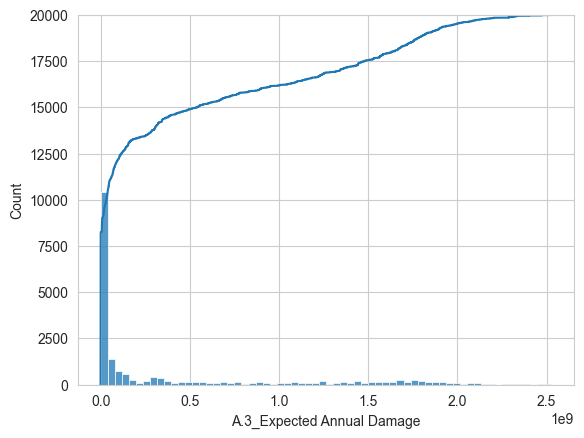

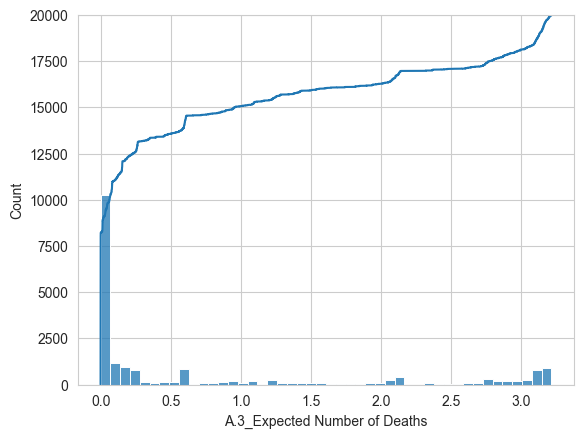

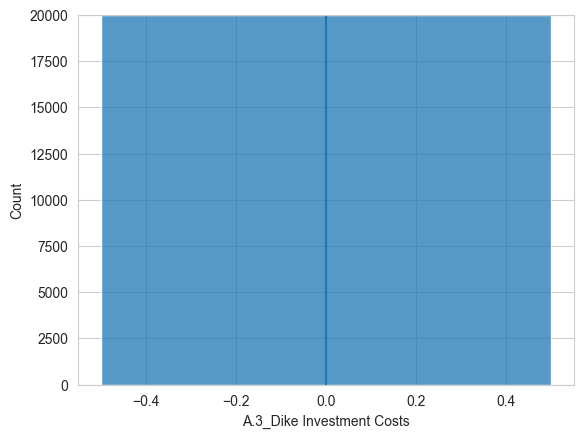

In [5]:
for o in ooi_dr3:
    sns.histplot(df_outcomes, x=o)
    sns.ecdfplot(df_outcomes, x=o, stat='count')
    plt.show()

The plots of the distributions of the OOI shows that for the status quo (i.e: no policy), the **A.3_Expected Annual Damage** and **A.3_Expected Number of Deaths** are relatively low.

The threshold for worse-case scenarios for these 2 OOIs are taken as the 90th value.

In [4]:
q_damage = 0.90
threshold_damage = df_outcomes['A.3_Expected Annual Damage'].quantile(q_damage)

q_death = 0.90
threshold_death = df_outcomes['A.3_Expected Number of Deaths'].quantile(q_death)

q_investment = 0.90
threshold_investment = df_outcomes['A.3_Dike Investment Costs'].quantile(q_investment)

threshold_dict = {
    'A.3_Expected Annual Damage': threshold_damage,
    'A.3_Expected Number of Deaths': threshold_death,
    'A.3_Dike Investment Costs': threshold_investment
}

## Relationship between A.3_Expected Annual Damage and A.3_Expected Number of Deaths

The stat model shows that there is a strong linear relationship between **A.3_Expected Number of Deaths** and **A.3_Expected Annual Damage** 

In [45]:
X = sm.add_constant(df_outcomes['A.3_Expected Annual Damage'])
Y = df_outcomes['A.3_Expected Number of Deaths']
regress_model_ooi = sm.OLS(Y,X)
regress_result_ooi = regress_model_ooi.fit()
regress_result_ooi.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     A.3_Expected Number of Deaths   R-squared:                       0.970
Model:                                       OLS   Adj. R-squared:                  0.970
Method:                            Least Squares   F-statistic:                 6.438e+05
Date:                           Thu, 06 Jun 2024   Prob (F-statistic):               0.00
Time:                                   09:54:40   Log-Likelihood:                 4834.0
No. Observations:                          20000   AIC:                            -9664.
Df Residuals:                              19998   BIC:                            -9648.
Df Model:                                      1                                         
Covariance Type:                       nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          0.0258      0.002     16.317      0.000       0.023       0.029
A.3_Expected Annual Damage   1.68e-09   2.09e-12    802.400      0.000    1.68e-09    1.68e-09
==============================================================================
Omnibus:                     3724.338   Durbin-Watson:                   0.454
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            80587.456
Skew:                           0.296   Prob(JB):                         0.00
Kurtosis:                      12.816   Cond. No.                     8.90e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.9e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

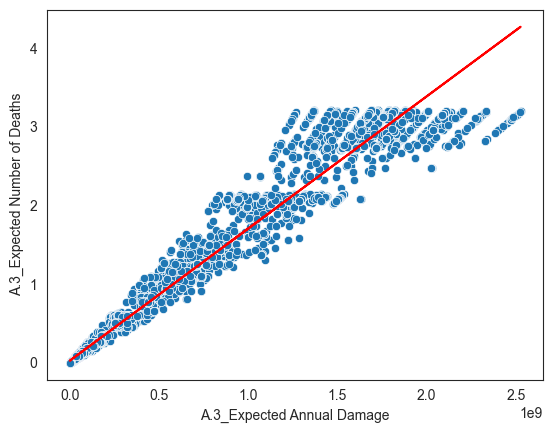

In [53]:
ax = plt.subplot()
y_graph = df_outcomes['A.3_Expected Annual Damage']*regress_result_ooi.params['A.3_Expected Annual Damage'] +  regress_result_ooi.params['const']
ax.plot(df_outcomes['A.3_Expected Annual Damage'], y_graph, color='r')
sns.scatterplot(df_outcomes, x='A.3_Expected Annual Damage', y='A.3_Expected Number of Deaths', ax=ax)
plt.show()

# Sensitivity analysis

Sensitivity analysis shows that:
* A.3_pfail has the most significant impact of the 2 OOIs of Dike Ring 3. This influence is mostly first order (i.e., the uncertainty has the impact by itself, not in combination with other uncertainties)
* A.1_pfail and A.2_pfail has some influence on the 2 OOIs of Dike Ring 3. These influence are much milder than that of A.3_pfail. Furthermore, these influences are not first order (i.e., they must be combined with other uncertainties)

This suggest that:
* Dike Ring 3 must push for policies to mitigate A.3_pfail as much as possible.
* Dike Ring 1 and 2 can be alliance since, mitigating their risks serve the cause of Dike Ring 3.

## Linear regression

The stat model for the 2 OOIs has R-squared values approximately 0.6, meaning that about 60% of the data points can be explained by this regression model.

The coef for these 2 OOIs resulting from the stat model is rather inexplicable.

In [16]:
# worse case scenarios only
X_0 = sm.add_constant(experiment[uncertainties])
for key in ooi_dr3:
    index = df_outcomes.loc[df_outcomes[key] > threshold_dict[key], key].index
    X_0 = sm.add_constant(experiment.loc[index, uncertainties])
    y = df_outcomes.loc[index, key]
    # print(y)
    est = sm.OLS(y, X_0.astype(float)).fit()
    print('\n\n' + '*'*100 + '\n')
    print(key)
    print(est.summary())
    print('-'*20 + '\nSorted coef values' + '-'*20)
    print(est.params.sort_values())



****************************************************************************************************

A.3_Expected Annual Damage
                                OLS Regression Results                                
Dep. Variable:     A.3_Expected Annual Damage   R-squared:                       0.839
Model:                                    OLS   Adj. R-squared:                  0.838
Method:                         Least Squares   F-statistic:                     541.2
Date:                        Mon, 10 Jun 2024   Prob (F-statistic):               0.00
Time:                                15:51:31   Log-Likelihood:                -39001.
No. Observations:                        1991   AIC:                         7.804e+04
Df Residuals:                            1971   BIC:                         7.815e+04
Df Model:                                  19                                         
Covariance Type:                    nonrobust                                         

ValueError: zero-size array to reduction operation maximum which has no identity

In [15]:
X_0 = sm.add_constant(experiment[uncertainties])
for key in ooi_dr3:
    est = sm.OLS(outcomes[key], X_0.astype(float)).fit()
    print('\n\n' + '*'*100 + '\n')
    print(key)
    print(est.summary())
    print('-'*20 + '\nSorted coef values' + '-'*20)
    print(est.params.sort_values())



****************************************************************************************************

A.3_Expected Annual Damage
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.612
Method:                 Least Squares   F-statistic:                     1659.
Date:                Mon, 10 Jun 2024   Prob (F-statistic):               0.00
Time:                        15:50:31   Log-Likelihood:            -4.2451e+05
No. Observations:               20000   AIC:                         8.491e+05
Df Residuals:                   19980   BIC:                         8.492e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025

/opt/homebrew/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/opt/homebrew/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1871: RuntimeWarning: invalid value encountered in scalar divide
  return self.mse_model/self.mse_resid
/opt/homebrew/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:957: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/opt/homebrew/lib/python3.12/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in scalar divide
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)


## Feature scoring

Feature scoring analysis shows that:
* the pfail of A.3 has the most influence on the 2 OOIs of dike ring 3.
* additionally the uncertainties dictating the failure (pfail) of dike ring A.1 has some influences on the 2 OOIs of dike ring 3, albeit not as significant. 
* additionally the uncertainties dictating the failure (pfail) of dike ring A.2 has some influences on the 2 OOIs of dike ring 3, albeit not less significant than that of A.1.

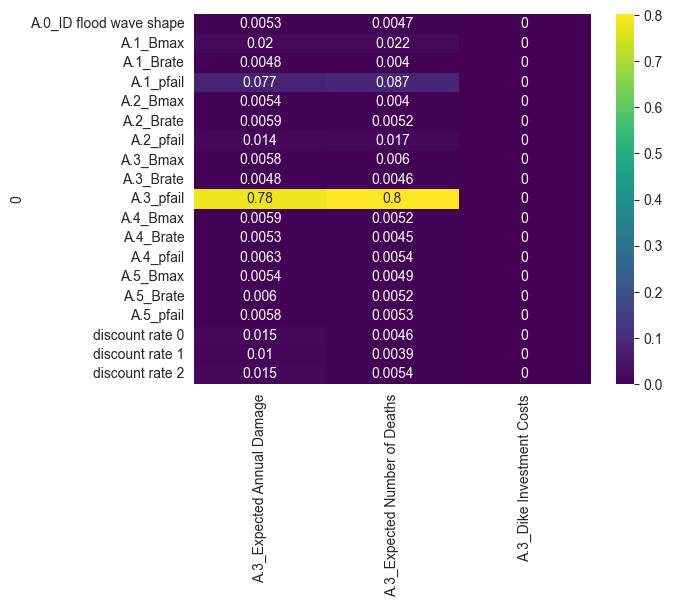

In [8]:
scores = feature_scoring.get_feature_scores_all(experiment[uncertainties], df_outcomes[ooi_dr3],
                                      max_features=0.6, mode=RuleInductionType.REGRESSION)
sns.heatmap(scores, annot=True, cmap='viridis')
plt.show()

## Sobol Indices

Sobol Indices analysis shows that:
* the pfail of A.3 has the most influence on the 2 OOIs of dike ring 3. This impact is primarily first order,
* additionally the uncertainties dictating the failure (pfail) of dike rings A.1 and A.2 also have somce influences on the 2 OOIs of dike ring 3, albeit not as significant. These impacts are not primarily first order impacts, indicating that these uncertainties must be combined with other uncertainties to influence these OOIs.


****************************************************************************************************

A.3_Expected Annual Damage
                                   ST       ST_conf
A.0_ID flood wave shape  5.895603e-03  2.616247e-03
A.1_Bmax                 1.909834e-02  9.303074e-03
A.1_Brate                1.642223e-04  1.795542e-04
A.1_pfail                1.676805e-01  6.360140e-02
A.2_Bmax                 2.381791e-04  3.341086e-04
A.2_Brate                3.827300e-07  5.324375e-07
A.2_pfail                3.193679e-02  2.127307e-02
A.3_Bmax                 0.000000e+00  0.000000e+00
A.3_Brate                0.000000e+00  0.000000e+00
A.3_pfail                9.184977e-01  1.126825e-01
A.4_Bmax                 0.000000e+00  0.000000e+00
A.4_Brate                0.000000e+00  0.000000e+00
A.4_pfail                0.000000e+00  0.000000e+00
A.5_Bmax                 0.000000e+00  0.000000e+00
A.5_Brate                0.000000e+00  0.000000e+00
A.5_pfail                0.000000e+00 

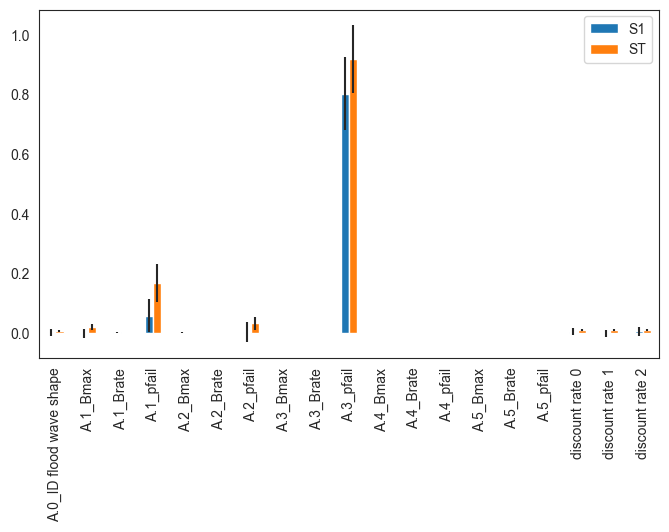


****************************************************************************************************

A.3_Expected Number of Deaths
                                   ST       ST_conf
A.0_ID flood wave shape  5.690504e-03  2.158136e-03
A.1_Bmax                 2.164792e-02  1.136021e-02
A.1_Brate                1.377938e-04  1.335541e-04
A.1_pfail                1.633267e-01  4.807247e-02
A.2_Bmax                 4.232157e-04  7.400854e-04
A.2_Brate                5.617616e-07  9.888168e-07
A.2_pfail                3.158118e-02  1.921771e-02
A.3_Bmax                 0.000000e+00  0.000000e+00
A.3_Brate                0.000000e+00  0.000000e+00
A.3_pfail                9.073108e-01  9.683382e-02
A.4_Bmax                 0.000000e+00  0.000000e+00
A.4_Brate                0.000000e+00  0.000000e+00
A.4_pfail                0.000000e+00  0.000000e+00
A.5_Bmax                 0.000000e+00  0.000000e+00
A.5_Brate                0.000000e+00  0.000000e+00
A.5_pfail                0.000000e+

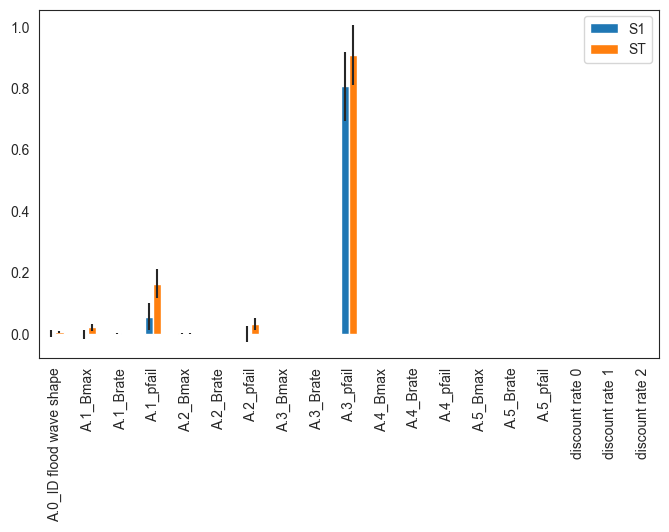


****************************************************************************************************

A.3_Dike Investment Costs


/opt/homebrew/lib/python3.12/site-packages/SALib/analyze/sobol.py:145: RuntimeWarning: invalid value encountered in divide
  Y = (Y - Y.mean()) / Y.std()


                         ST  ST_conf
A.0_ID flood wave shape NaN      NaN
A.1_Bmax                NaN      NaN
A.1_Brate               NaN      NaN
A.1_pfail               NaN      NaN
A.2_Bmax                NaN      NaN
A.2_Brate               NaN      NaN
A.2_pfail               NaN      NaN
A.3_Bmax                NaN      NaN
A.3_Brate               NaN      NaN
A.3_pfail               NaN      NaN
A.4_Bmax                NaN      NaN
A.4_Brate               NaN      NaN
A.4_pfail               NaN      NaN
A.5_Bmax                NaN      NaN
A.5_Brate               NaN      NaN
A.5_pfail               NaN      NaN
discount rate 0         NaN      NaN
discount rate 1         NaN      NaN
discount rate 2         NaN      NaN
                         S1  S1_conf
A.0_ID flood wave shape NaN      NaN
A.1_Bmax                NaN      NaN
A.1_Brate               NaN      NaN
A.1_pfail               NaN      NaN
A.2_Bmax                NaN      NaN
A.2_Brate               NaN      NaN
A

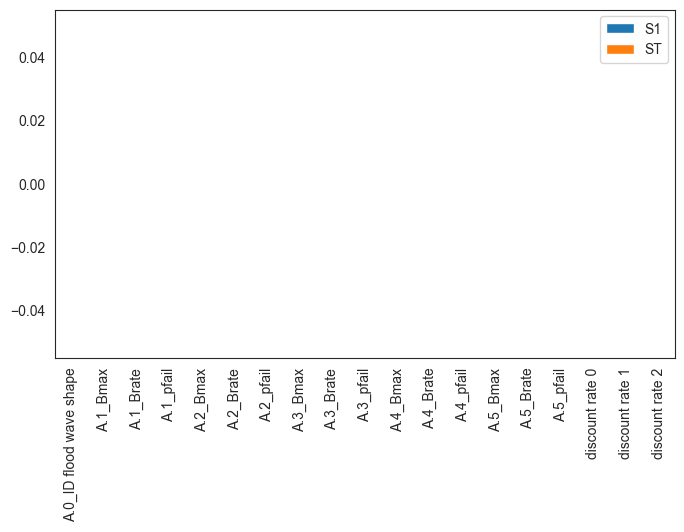

In [9]:
problem = get_SALib_problem(dike_model.uncertainties)
for key in ooi_dr3:
    print('\n' + '*'*100 + '\n')
    print(key)
    Si = sobol.analyze(problem, outcomes[key], calc_second_order=True, print_to_console=True)
    Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
    Si_df = pd.DataFrame(Si_filter, index=problem['names'])
    
    sns.set_style('white')
    fig, ax = plt.subplots(1)
    
    indices = Si_df[['S1','ST']]
    err = Si_df[['S1_conf','ST_conf']]
    
    indices.plot.bar(yerr=err.values.T,ax=ax)
    fig.set_size_inches(8,6)
    fig.subplots_adjust(bottom=0.3)
    plt.show()
    
    # fig, axes = plt.subplots(1,3)
    # fig.set_size_inches(8, 4)
    # Si.plot(ax=axes)
    # plt.show()
    # si.plot()

# Scenario discovery

Steps:
* Perform different scenario discovery techniques to find the set of uncertainties and their value ranges that results in the 2 OOIs is above the 90th percentile values:
    * Dimensional stacking
    * PRIM 
    * CART 
* Identify the common set among these 3 techniques to derive the scenarios of interest

Results:
The 3 techniques yield consistent results regarding the uncertainties causing the worse-case scenarios and their value ranges. So, 3 scenarios are selected, which are taken from box 1, box 2 and box 3 of the CART algorithm to be the scenarios to run optimization on. They are:

|           | box_1_max          | box_2_max         | box_3_max          |
|-----------|--------------------|-------------------|--------------------|
| A.3_pfail | 0.17164792865514755 | 0.17164792865514755 | 0.17164792865514755 |
| A.1_pfail | 0.3404737710952759 | 0.998965362086892 | 0.998965362086892  |
| A.2_pfail | 0.9992654966190456 | 0.50148606300354  | 0.9992654966190456 | 


## Dimensional stacking

Results show that:
* For **A.3_Expected Number of Deaths** falls into the 90th percentile when:
    * A.1_pfail is in the range 0.33 and 1.0
    * A.3_pfail is in the range 0.33 and 0
    * A.2_pfail is in the range 0.33 and 1.0
* For **A.3_Expected Annual Damage** falls into the 90th percentile when:
    * A.1_pfail is in the range 0.33 and 1.0
    * discount rate 2 is in 1-4
    * A.3_pfail is in the range 0.33 and 0
    * discount rate 0 is in 1-4 

These results are consistent with the sensitivity analysis (SOBOL, Feature scoring) above.


****************************************************************************************************

A.3_Expected Annual Damage


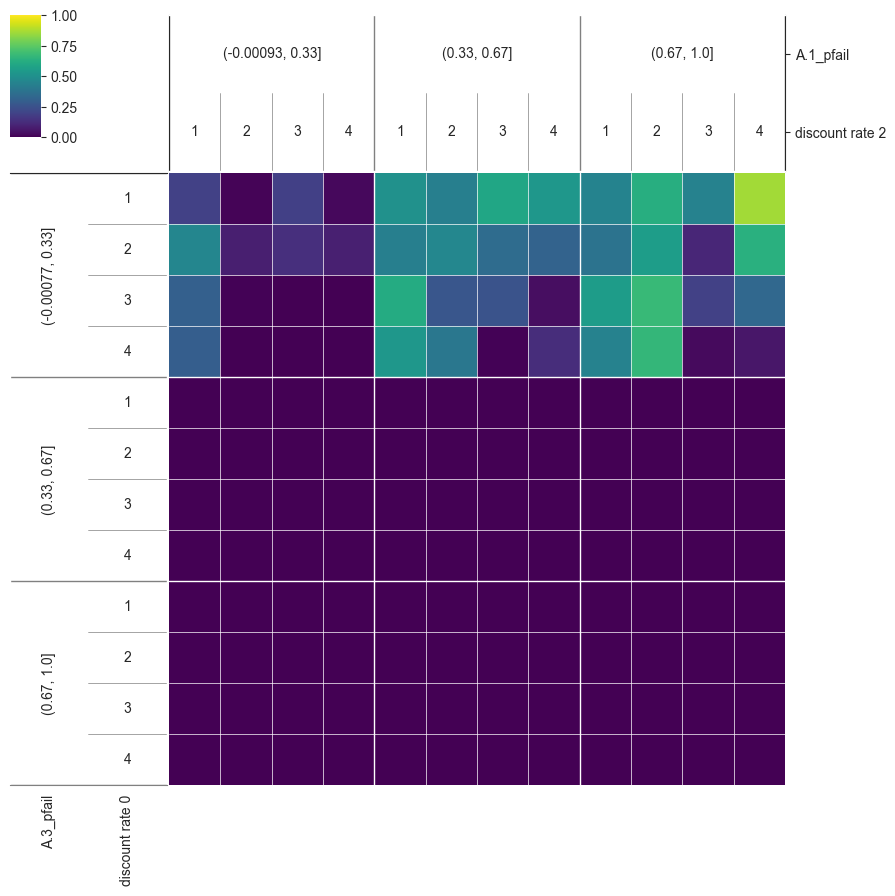


****************************************************************************************************

A.3_Expected Number of Deaths


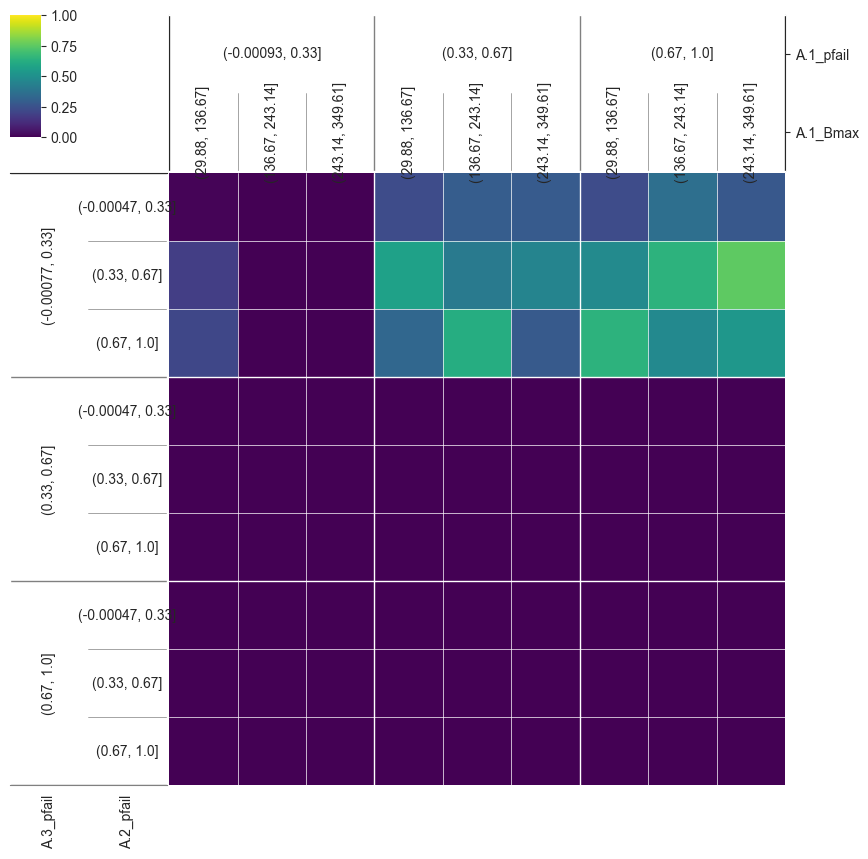


****************************************************************************************************

A.3_Dike Investment Costs


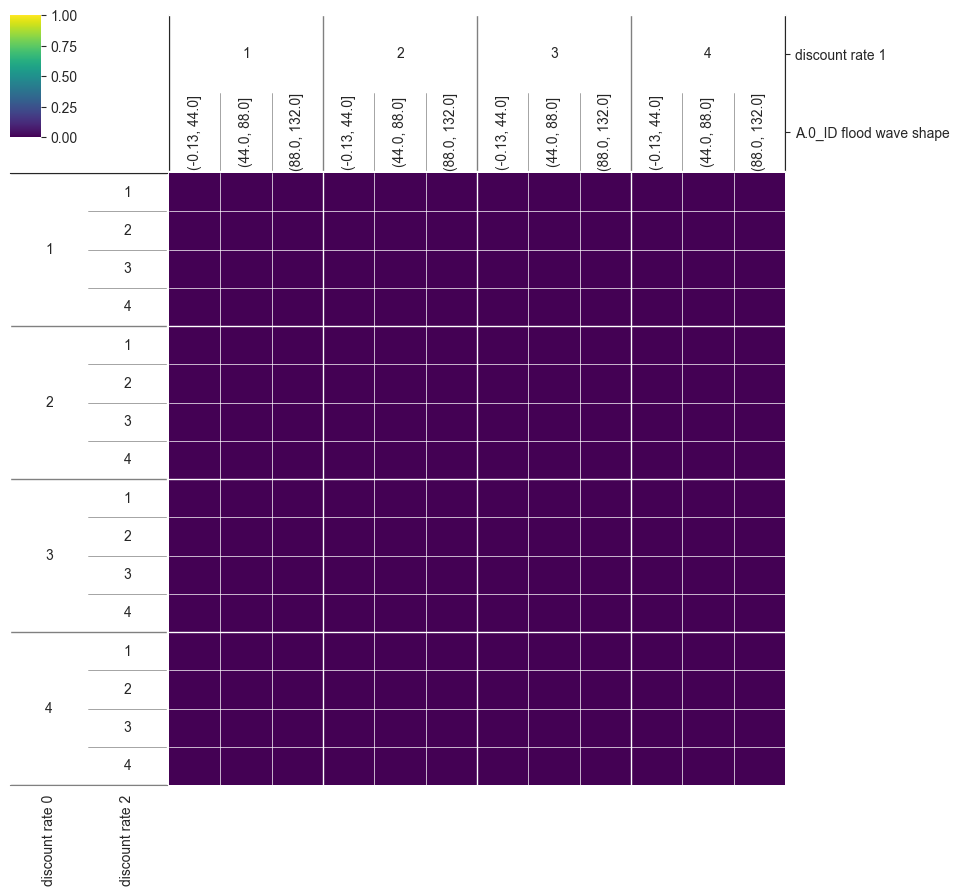

In [26]:
x = experiment[uncertainties]
for key in ooi_dr3:
    print('\n' + '*'*100 + '\n')
    print(key)
    y = (df_outcomes[key] > threshold_dict[key]).values
    dimensional_stacking.create_pivot_plot(x, y, 2, nbins=3, bin_labels=True)
    plt.show()

## PRIM
Goals
* Identify scenarios that are worse off for the OOI of Dike Ring 3.

Steps
* Use PRIM to find scenarios where **A.3_Expected Number of Death** is above the accepted threshold
* Use PRIM to find scenarios where **A.3_Expected Number of Death** and **A.3_Expected Annual Damage** is above the accepted threshold

Results
* A.2_pfail is between 0.52, 1
* A.1_Bmax is between 30, 3e2
* A.3_pfail is between 0, 0.48

These results are consistent with the sensitivity analysis (SOBOL, Feature scoring) above.

### A.3_Expected Number of Death

In [10]:
ema_logging.log_to_stderr(ema_logging.INFO)
x = experiment[uncertainties]
y = (df_outcomes['A.3_Expected Number of Deaths'] > threshold_death).values

prim_alg_0_death = prim.Prim(x, y, threshold=0.8, peel_alpha=0.05)
box1_0_death = prim_alg_0_death.find_box()

[MainProcess/INFO] 20000 points remaining, containing 1992 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.0623, coverage: 0.6255020080321285, density: 1.0 restricted_dimensions: 4


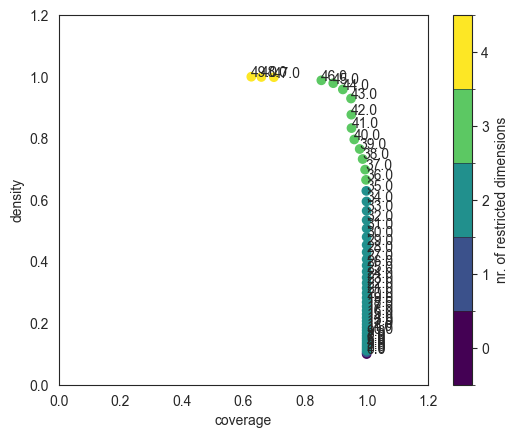

In [11]:
box1_0_death.show_tradeoff(annotated=True)
plt.show()

[<Figure size 640x480 with 1 Axes>]

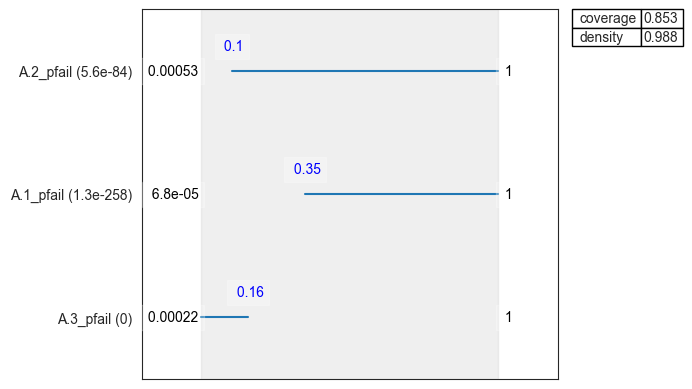

In [12]:
box1_0_death_index = box1_0_death.peeling_trajectory[(box1_0_death.peeling_trajectory.density >= 0.7) & (box1_0_death.peeling_trajectory.coverage >= 0.7)].index
point = int(box1_0_death_index[-1])
box1_0_death.inspect(point, style='graph')

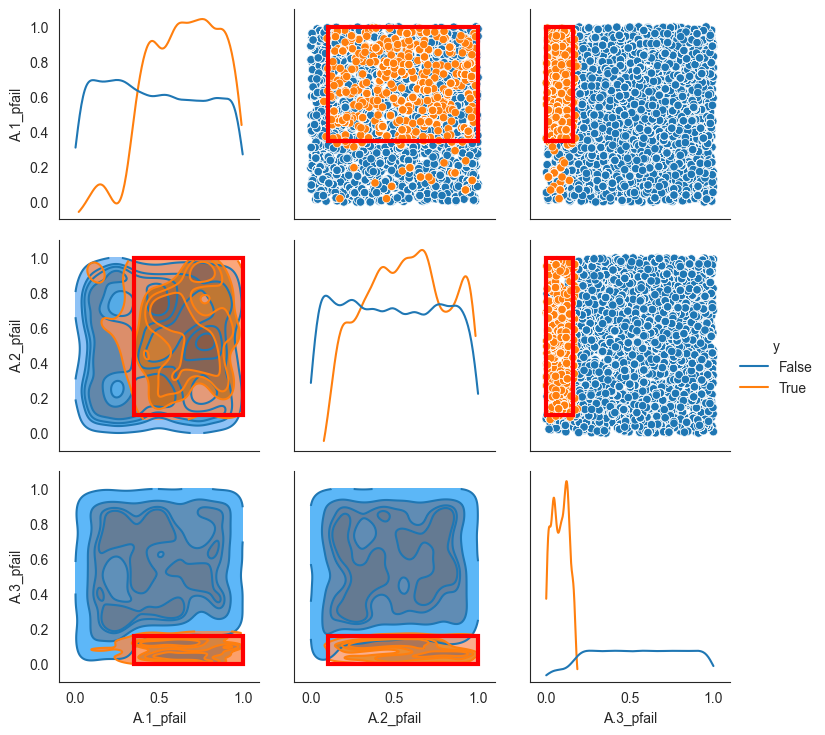

In [13]:
box1_0_death.show_pairs_scatter(point)

In [14]:
box1_0_death.resample(point)

[MainProcess/INFO] resample 0
[MainProcess/INFO] resample 1
[MainProcess/INFO] resample 2
[MainProcess/INFO] resample 3
[MainProcess/INFO] resample 4
[MainProcess/INFO] resample 5
[MainProcess/INFO] resample 6
[MainProcess/INFO] resample 7
[MainProcess/INFO] resample 8
[MainProcess/INFO] resample 9


,reproduce coverage,reproduce density
A.1_pfail,100.0,100.0
A.2_pfail,100.0,100.0
A.3_pfail,100.0,100.0
A.4_pfail,30.0,30.0
A.2_Bmax,10.0,10.0
discount rate 0,0.0,0.0
discount rate 1,0.0,0.0
discount rate 2,0.0,0.0
A.0_ID flood wave shape,0.0,0.0
A.1_Bmax,0.0,0.0


### A.3_Expected Number of Death and A.3_Expected Annual Damage

In [15]:
ema_logging.log_to_stderr(ema_logging.INFO)
x = experiment[uncertainties]
y = ((df_outcomes['A.3_Expected Number of Deaths'] > threshold_death) & (df_outcomes['A.3_Expected Annual Damage'] > threshold_damage)).values

prim_alg_0_death_damage = prim.Prim(x, y, threshold=0.8, peel_alpha=0.05)
box1_0_death_damage = prim_alg_0_death_damage.find_box()

[MainProcess/INFO] 20000 points remaining, containing 1490 cases of interest
[MainProcess/INFO] mean: 0.8318777292576419, mass: 0.0687, coverage: 0.7671140939597315, density: 0.8318777292576419 restricted_dimensions: 4


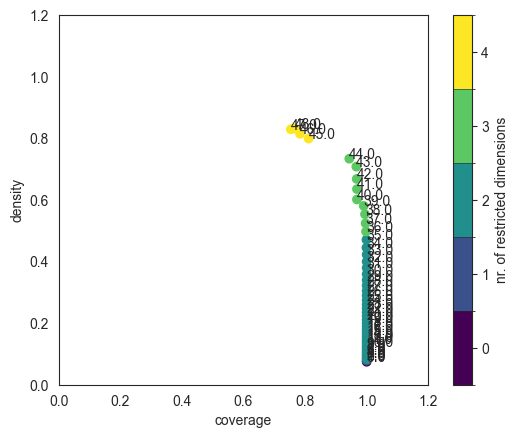

In [16]:
box1_0_death_damage.show_tradeoff(annotated=True)
plt.show()

[<Figure size 640x480 with 1 Axes>]

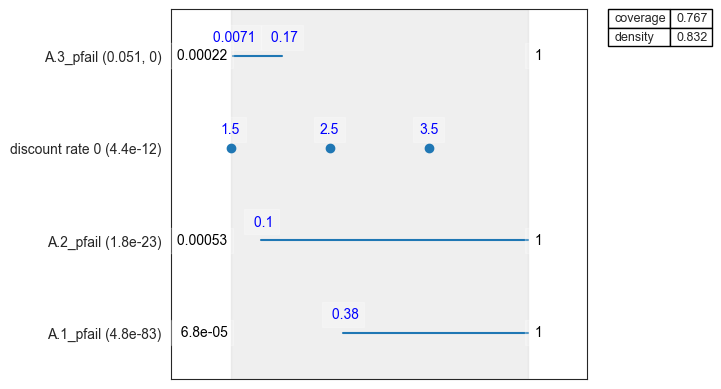

In [17]:
box1_0_death_damage_index = box1_0_death_damage.peeling_trajectory[(box1_0_death_damage.peeling_trajectory.density >= 0.7) & (box1_0_death_damage.peeling_trajectory.coverage >= 0.7)].index
point = int(box1_0_death_damage_index[-1])
box1_0_death_damage.inspect(point, style='graph')

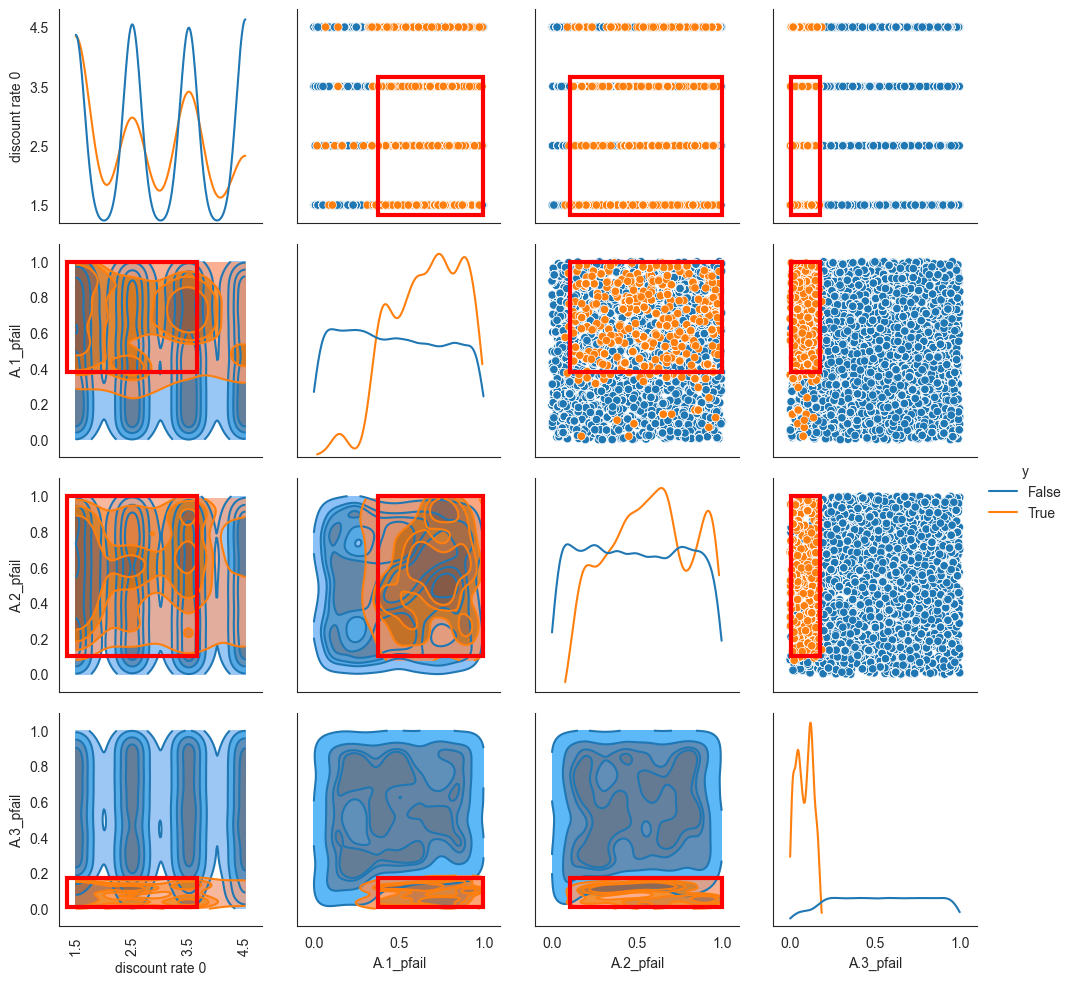

In [18]:
box1_0_death_damage.show_pairs_scatter(point)

## Cart

The results show that the uncertainties resulting in the 2 OOIs values to be above the 90th threshold are: A.3_pfail, A.1_pfail, A.1_pfail. These uncertainties are consistent with the sensititivy analysis above.

There are 5 scenarios, corresponding to the 5 leaf nodes of the CART, where the 2 OOIs values are above the 90th threshold. Among these 5 boxes, the ranges in box 1, box 2 and box 3 are in accordance with the 2 scenario discovery results from dimensional stacking and PRIM box above. So, the upper bound of box 1, box 2 and box 3 are selected to be the scenarios to find optimization for,

### A.3_Expected Number of Death

In [32]:
ema_logging.log_to_stderr(ema_logging.INFO)
x = experiment[uncertainties]
y = (df_outcomes['A.3_Expected Number of Deaths'] > threshold_death).values

cart_alg_0_death = cart.CART(x, y, 0.05)
cart_alg_0_death.build_tree()
cart_alg_0_death.boxes_to_dataframe()

box 1               box 2               box 3            \
                min       max       min       max       min       max   
A.3_pfail  0.000225  0.171648  0.000225  0.171648  0.000225  0.171648   
A.1_pfail  0.000068  0.325567  0.325567  0.998965  0.325567  0.998965   
A.2_pfail  0.000532  0.999265  0.000532  0.501486  0.501486  0.999265   

              box 4               box 5            
                min       max       min       max  
A.3_pfail  0.171648  0.220452  0.220452  0.998822  
A.1_pfail  0.000068  0.998965  0.000068  0.998965  
A.2_pfail  0.000532  0.999265  0.000532  0.999265

### A.3_Expected Number of Death and A.3_Expected Annual Damage

In [5]:
ema_logging.log_to_stderr(ema_logging.INFO)
x = experiment[uncertainties]
y = ((df_outcomes['A.3_Expected Number of Deaths'] > threshold_death) & (df_outcomes['A.3_Expected Annual Damage'] > threshold_damage)).values

cart_alg_0_death_damage = cart.CART(x, y, 0.05)
cart_alg_0_death_damage.build_tree()
cart_alg_0_death_damage.boxes_to_dataframe()

box 1               box 2               box 3            \
                min       max       min       max       min       max   
A.3_pfail  0.000225  0.171648  0.000225  0.171648  0.000225  0.171648   
A.1_pfail  0.000068  0.340474  0.340474  0.998965  0.340474  0.998965   
A.2_pfail  0.000532  0.999265  0.000532  0.501486  0.501486  0.999265   

              box 4               box 5            
                min       max       min       max  
A.3_pfail  0.171648  0.220452  0.220452  0.998822  
A.1_pfail  0.000068  0.998965  0.000068  0.998965  
A.2_pfail  0.000532  0.999265  0.000532  0.999265

In [6]:
num_boxes = len(cart_alg_0_death_damage.boxes)
scenarios_raw = cart_alg_0_death_damage.boxes_to_dataframe()[[(f'box {i+1}', 'max') for i in range(num_boxes)]]
scenarios_raw.columns = scenarios_raw.columns.get_level_values(0) + " " + scenarios_raw.columns.get_level_values(1)
scenarios_raw = scenarios_raw.rename(columns={col : '_'.join(col.split(" ")) for col in scenarios_raw.columns})

# create scenario dict to run optimize()
scenarios_dict = scenarios_raw.to_dict('dict')

# write scenarios to csv
scenarios_raw.to_csv(os.path.join('experiment', 'scenario_cart.csv'))

# Robustness

Steps:
* For each of the 3 selected scenarios from CART, use MOEA to find a set of optimal policies with multiple seeds. The configurations is: nfe = 100000, 5 seeds.
    * Inspect convergence of metrics with nfe values to determine if selected nfe value is sufficient
    * Use parallel coords to inspect trade-off of different OOIs
* For each set of optimal policies:
    * Run experiments. Use experiment data to perform sensitivity analysis and scenario discovery to identify where these policies might fail.    

## MOEA
The script to perform MOEA is in the python file dike_model_simulation_policy_search.py. The results are saved in the directory MORDM.

The results analysis shows that:


## Convergence investigation

In [24]:
dummy_model, planning_step = get_model_for_problem_formulation(8)
for u in dummy_model.levers:
    u.name = 'z_' + '_'.join(u.name.split(" "))
    u.name = u.name.replace('.', 'z')
    
for u in dummy_model.outcomes:
    u.name = 'z_' + '_'.join(u.name.split(" "))
    u.name = u.name.replace('.', 'z')

for u in dummy_model.uncertainties:
    u.name = 'z_' + '_'.join(u.name.split(" "))
    u.name = u.name.replace('.', 'z')


def calculate_metrics(archives, reference_set, model=dummy_model):
    problem = to_problem(model, searchover="levers")

    hv = HypervolumeMetric(reference_set, problem)
    gd = GenerationalDistanceMetric(reference_set, problem, d=1)
    ei = EpsilonIndicatorMetric(reference_set, problem)
    ig = InvertedGenerationalDistanceMetric(reference_set, problem, d=1)
    sm = SpacingMetric(problem)

    metrics = []
    for nfe, archive in archives.items():
        scores = {
            "generational_distance": gd.calculate(archive),
            "hypervolume": hv.calculate(archive),
            "epsilon_indicator": ei.calculate(archive),
            "inverted_gd": ig.calculate(archive),
            "spacing": sm.calculate(archive),
            "nfe": int(nfe),
        }
        metrics.append(scores)
    metrics = pd.DataFrame.from_dict(metrics)

    # sort metrics by number of function evaluations
    metrics.sort_values(by="nfe", inplace=True)
    return metrics


def plot_metrics(metrics, convergence):
    sns.set_style("white")
    fig, axes = plt.subplots(nrows=6, figsize=(8, 12), sharex=True)

    ax1, ax2, ax3, ax4, ax5, ax6 = axes

    ax1.plot(metrics.nfe, metrics.hypervolume)
    ax1.set_ylabel("hypervolume")

    ax2.plot(convergence.nfe, convergence.epsilon_progress)
    ax2.set_ylabel("$\epsilon$ progress")

    ax3.plot(metrics.nfe, metrics.generational_distance)
    ax3.set_ylabel("generational distance")

    ax4.plot(metrics.nfe, metrics.epsilon_indicator)
    ax4.set_ylabel("epsilon indicator")

    ax5.plot(metrics.nfe, metrics.inverted_gd)
    ax5.set_ylabel("inverted generational\ndistance")

    ax6.plot(metrics.nfe, metrics.spacing)
    ax6.set_ylabel("spacing")

    ax6.set_xlabel("nfe")

    sns.despine(fig)

<>:52: SyntaxWarning: invalid escape sequence '\e'
<>:52: SyntaxWarning: invalid escape sequence '\e'
/var/folders/kh/8ls_kfyd28j3v0nb9fsj54g00000gn/T/ipykernel_87697/528301480.py:52: SyntaxWarning: invalid escape sequence '\e'
  ax2.set_ylabel("$\epsilon$ progress")


<>:35: SyntaxWarning: invalid escape sequence '\e'
<>:35: SyntaxWarning: invalid escape sequence '\e'
/var/folders/kh/8ls_kfyd28j3v0nb9fsj54g00000gn/T/ipykernel_87697/1955151187.py:35: SyntaxWarning: invalid escape sequence '\e'
  ax2.set_ylabel("$\epsilon$ progress")
/opt/homebrew/lib/python3.12/site-packages/ema_workbench/em_framework/optimization.py:786: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat(results, ignore_index=True)


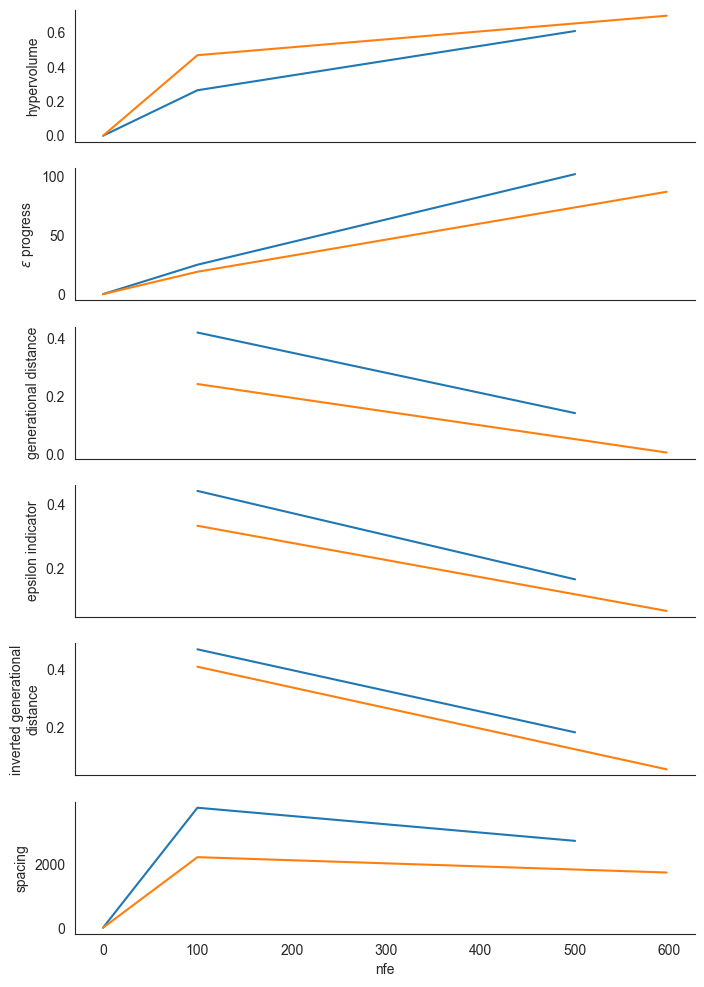

In [31]:
merge_archs = []
metrics = []
archives = []
for i in range(2):
    arch = ArchiveLogger.load_archives(os.path.join('experiment', f'results_optimize_box_1_max_{i}.tar.gz'))
    for key in arch.keys():
        arch[key] = arch[key].drop(columns='Unnamed: 0')
        arch[key] = arch[key].rename(columns={ x: 'z_' + "_".join(x.split(" ")) for x in arch[key].columns}) 
        arch[key] = arch[key].rename(columns={ x: x.replace('.', 'z') for x in arch[key].columns})
    merge_archs.extend([val for val in arch.values()])
    archives.append(arch)
# type(merge_archs[0])
reference_set = epsilon_nondominated(merge_archs, [0.025] * len(dummy_model.outcomes), to_problem(dummy_model, searchover="levers"))

for arch in archives:
    metric = calculate_metrics(arch, reference_set)
    metrics.append(metric)

convergences = [pd.read_csv(os.path.join('experiment', f'convergence_results_optimize_box_1_max_{i}.csv')) for i in range(2)]
# metrics = calculate_metrics(archives, reference_set)
# plot_metrics(metrics, convergence)

sns.set_style("white")
fig, axes = plt.subplots(nrows=6, figsize=(8, 12), sharex=True)

ax1, ax2, ax3, ax4, ax5, ax6 = axes


for metric, convergence in zip(metrics, convergences):
    # plot_metrics(metric, convergence)
    ax1.plot(metric.nfe, metric.hypervolume)
    ax1.set_ylabel("hypervolume")

    ax2.plot(convergence.nfe, convergence.epsilon_progress)
    ax2.set_ylabel("$\epsilon$ progress")

    ax3.plot(metric.nfe, metric.generational_distance)
    ax3.set_ylabel("generational distance")

    ax4.plot(metric.nfe, metric.epsilon_indicator)
    ax4.set_ylabel("epsilon indicator")

    ax5.plot(metric.nfe, metric.inverted_gd)
    ax5.set_ylabel("inverted generational\ndistance")

    ax6.plot(metric.nfe, metric.spacing)
    ax6.set_ylabel("spacing")

ax6.set_xlabel("nfe")


sns.despine(fig)

plt.show()
# plt.show()

In [30]:
convergences[0].nfe

0      0
1    100
2    500
Name: nfe, dtype: int64

# Old results. will be removed

In [7]:
q_damage = 0.90
threshold_damage = df_outcomes['A.3_Expected Annual Damage'].quantile(q_damage)
threshold_investment = 10e9

q_death = 0.90
threshold_death = df_outcomes['A.3_Expected Number of Deaths'].quantile(q_damage)


# threshold_damage = df_outcomes['A.3_Expected Annual Damage'].max()
# threshold_death = df_outcomes['A.3_Expected Number of Deaths'].max()

threshold_damage = 10e20
threshold_death = 1000

print(f'Threshold death {threshold_death} person')
print(f'Threshold damage {threshold_damage} euro')
# print(f'Threshold investment {threshold_investment} euro')

Threshold death 1000 person
Threshold damage 1e+21 euro


In [8]:
reference_values = {
        "Bmax": 175,
        "Brate": 1.5,
        "pfail": 0.5,
        "ID flood wave shape": 4,
        "planning steps": 2,
    }
reference_values.update({f"discount rate {n}": 3.5 for n in planning_step})
scen1 = {}

for key in dike_model.uncertainties:
    name_split = key.name.split("_")

    if len(name_split) == 1:
        scen1.update({key.name: reference_values[key.name]})

    else:
        scen1.update({key.name: reference_values[name_split[1]]})

for key in scenarios_dict['box_1_max']:
    scen1.update({key: scenarios_dict['box_1_max'][key]})

ref_scenario = Scenario("reference", **scen1)

In [10]:
buf_model, planning_step = get_model_for_problem_formulation(8)
convergence_metrics = [ArchiveLogger(
                        "experiment",
                        [l.name for l in buf_model.levers],
                        [o.name for o in buf_model.outcomes],
                        base_filename="optimize_test.tar.gz",
                        ),
                        EpsilonProgress(),
                        ]

# convergence_metrics = [ArchiveLogger(
#                         "experiment",
#                         [l.name for l in dike_model.levers],
#                         [o.name for o in dike_model.outcomes],
#                         base_filename="optimize_test.tar.gz",
#                         ),
#                         EpsilonProgress(),
#                         ]


# constraints = [Constraint("max expected number of death", outcome_names="A.3_Expected Number of Deaths",
#                           function=lambda x:max(0, x-threshold_death)),
#                Constraint("max expected annual damage", outcome_names="A.3_Expected Annual Damage",
#                           function=lambda x:max(0, x-threshold_damage)),
#                Constraint("max expected dike investment cost", outcome_names="A.3_Dike Investment Costs",
#                           function=lambda x:max(0, x-threshold_investment))]
# constraints = [Constraint("max expected number of death", outcome_names="A.3_Expected Number of Deaths",
#                           function=lambda x:max(0, x-threshold_death)),
#                Constraint("max expected annual damage", outcome_names="A.3_Expected Annual Damage",
#                           function=lambda x:max(0, x-threshold_damage))]

ema_logging.log_to_stderr(ema_logging.INFO)

nfe = 500


with MultiprocessingEvaluator(buf_model) as evaluator:
    # results, convergence = evaluator.optimize(nfe=nfe, 
    #                                           searchover='levers',
    #                                           reference=ref_scenario,
    #                                           epsilons=[0.0025] * len(constraints), ## len(ooi)
    #                                           convergence=convergence_metrics,
    #                                           constraints=constraints)
    results, convergence = evaluator.optimize(nfe=nfe, 
                                              searchover='levers',
                                              reference=ref_scenario,
                                              epsilons=[0.025] * len(buf_model.outcomes), ## len(ooi)
                                              convergence=convergence_metrics)

[MainProcess/INFO] pool started with 8 workers
599it [00:16, 35.74it/s]                                                       
[MainProcess/INFO] optimization completed, found 23 solutions
[MainProcess/INFO] terminating pool


In [13]:
results[[o.name for o in buf_model.outcomes]].describe()

,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths,A.3_Expected Annual Damage,A.3_Expected Number of Deaths
count,2.300000e+01,2.300000e+01,23.000000,23.000000,2.300000e+01,23.000000
mean,4.785646e+08,3.509783e+08,1721.891742,0.036614,3.680955e+07,0.032060
std,1.130506e+08,3.193000e+08,4267.518979,0.107033,8.014618e+07,0.107679
min,3.006350e+08,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000
25%,3.866516e+08,1.182500e+08,0.000000,0.000037,0.000000e+00,0.000000
50%,4.761533e+08,2.672000e+08,31.578961,0.005272,4.648269e+06,0.002415
75%,5.496995e+08,5.217500e+08,894.740802,0.027649,1.438291e+07,0.012894
max,7.538623e+08,1.313100e+09,15169.138575,0.520153,2.543419e+08,0.520153


In [20]:
convergence

,epsilon_progress,nfe
0,0,0
1,3,100
2,3,1199
3,3,2290
4,3,3385
5,3,4081


In [18]:
# To get the nfe graph, run this cell
# dummy_model, planning_step = get_model_for_problem_formulation(problem_formulation_id)
dummy_model, planning_step = get_model_for_problem_formulation(8)
for u in dummy_model.levers:
    u.name = 'z_' + '_'.join(u.name.split(" "))
    u.name = u.name.replace('.', 'z')
    
for u in dummy_model.outcomes:
    u.name = 'z_' + '_'.join(u.name.split(" "))
    u.name = u.name.replace('.', 'z')

for u in dummy_model.uncertainties:
    u.name = 'z_' + '_'.join(u.name.split(" "))
    u.name = u.name.replace('.', 'z')

def calculate_metrics(archives, reference_set, model=dummy_model):
    problem = to_problem(model, searchover="levers")

    hv = HypervolumeMetric(reference_set, problem)
    gd = GenerationalDistanceMetric(reference_set, problem, d=1)
    ei = EpsilonIndicatorMetric(reference_set, problem)
    ig = InvertedGenerationalDistanceMetric(reference_set, problem, d=1)
    sm = SpacingMetric(problem)

    metrics = []
    for nfe, archive in archives.items():
        scores = {
            "generational_distance": gd.calculate(archive),
            "hypervolume": hv.calculate(archive),
            "epsilon_indicator": ei.calculate(archive),
            "inverted_gd": ig.calculate(archive),
            "spacing": sm.calculate(archive),
            "nfe": int(nfe),
        }
        metrics.append(scores)
    metrics = pd.DataFrame.from_dict(metrics)

    # sort metrics by number of function evaluations
    metrics.sort_values(by="nfe", inplace=True)
    return metrics

# def plot_metrics(metrics):
#     sns.set_style("white")
#     fig, axes = plt.subplots(nrows=6, figsize=(8, 12), sharex=True)
# 
#     ax1, ax2, ax3, ax4, ax5, ax6 = axes
# 
#     ax1.plot(metrics.nfe, metrics.hypervolume)
#     ax1.set_ylabel("hypervolume")
# 
#     # ax2.plot(convergence.nfe, convergence.epsilon_progress)
#     # ax2.set_ylabel("$\epsilon$ progress")
# 
#     ax3.plot(metrics.nfe, metrics.generational_distance)
#     ax3.set_ylabel("generational distance")
# 
#     ax4.plot(metrics.nfe, metrics.epsilon_indicator)
#     ax4.set_ylabel("epsilon indicator")
# 
#     ax5.plot(metrics.nfe, metrics.inverted_gd)
#     ax5.set_ylabel("inverted generational\ndistance")
# 
#     ax6.plot(metrics.nfe, metrics.spacing)
#     ax6.set_ylabel("spacing")
# 
#     ax6.set_xlabel("nfe")
# 
#     sns.despine(fig)


def plot_metrics(metrics, convergence):
    sns.set_style("white")
    fig, axes = plt.subplots(nrows=6, figsize=(8, 12), sharex=True)

    ax1, ax2, ax3, ax4, ax5, ax6 = axes

    ax1.plot(metrics.nfe, metrics.hypervolume)
    ax1.set_ylabel("hypervolume")

    ax2.plot(convergence.nfe, convergence.epsilon_progress)
    ax2.set_ylabel("$\epsilon$ progress")

    ax3.plot(metrics.nfe, metrics.generational_distance)
    ax3.set_ylabel("generational distance")

    ax4.plot(metrics.nfe, metrics.epsilon_indicator)
    ax4.set_ylabel("epsilon indicator")

    ax5.plot(metrics.nfe, metrics.inverted_gd)
    ax5.set_ylabel("inverted generational\ndistance")

    ax6.plot(metrics.nfe, metrics.spacing)
    ax6.set_ylabel("spacing")

    ax6.set_xlabel("nfe")

    sns.despine(fig)

<>:81: SyntaxWarning: invalid escape sequence '\e'
<>:81: SyntaxWarning: invalid escape sequence '\e'
/var/folders/kh/8ls_kfyd28j3v0nb9fsj54g00000gn/T/ipykernel_87697/2461600078.py:81: SyntaxWarning: invalid escape sequence '\e'
  ax2.set_ylabel("$\epsilon$ progress")


In [100]:
archs = []
for i in range(5):
    arch = ArchiveLogger.load_archives(os.path.join('mordm', f'results_optimize_box_1_max_{i}.tar.gz'))
    for key in arch.keys():
        arch[key] = arch[key].drop(columns='Unnamed: 0')
        arch[key] = arch[key].rename(columns={ x: 'z_' + "_".join(x.split(" ")) for x in arch[key].columns}) 
        arch[key] = arch[key].rename(columns={ x: x.replace('.', 'z') for x in arch[key].columns})
    archs.extend([val for val in arch.values()])
# type(archs[0])
reference_set = epsilon_nondominated(archs, [0.025] * len(ooi), to_problem(dummy_model, searchover="levers"))

/opt/homebrew/lib/python3.12/site-packages/ema_workbench/em_framework/optimization.py:786: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat(results, ignore_index=True)


/var/folders/kh/8ls_kfyd28j3v0nb9fsj54g00000gn/T/ipykernel_2155/4161161189.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  buf = pd.concat(archs)


,z_0_RfR_0,z_0_RfR_1,z_0_RfR_2,z_1_RfR_0,z_1_RfR_1,z_1_RfR_2,z_2_RfR_0,z_2_RfR_1,z_2_RfR_2,z_3_RfR_0,...,z_Az3_DikeIncrease_2,z_Az4_DikeIncrease_0,z_Az4_DikeIncrease_1,z_Az4_DikeIncrease_2,z_Az5_DikeIncrease_0,z_Az5_DikeIncrease_1,z_Az5_DikeIncrease_2,z_Az3_Expected_Annual_Damage,z_Az3_Dike_Investment_Costs,z_Az3_Expected_Number_of_Deaths
0,0,1,1,1,1,1,1,1,1,1,...,0,5,6,6,4,7,1,6.791036e+06,2.029929e+07,0.001702
1,0,1,0,1,0,1,1,1,1,1,...,0,6,0,5,3,6,9,6.791036e+06,2.029929e+07,0.001702
2,0,0,0,0,0,0,1,1,1,1,...,0,6,0,3,6,3,4,2.263679e+06,2.029929e+07,0.000567
3,0,0,0,1,1,0,1,1,1,1,...,0,5,6,5,5,2,4,6.791036e+06,2.029929e+07,0.001702
4,0,0,1,1,0,1,1,1,1,1,...,0,9,7,8,7,3,2,6.841160e+06,2.029929e+07,0.002151
5,0,1,1,0,0,0,1,1,1,1,...,0,3,6,5,6,2,3,6.791036e+06,2.029929e+07,0.001702
6,0,0,0,1,0,0,1,1,1,1,...,0,6,7,0,1,3,5,2.263679e+06,2.029929e+07,0.000567
7,0,0,0,0,0,1,1,1,1,1,...,0,5,4,5,4,1,3,4.594190e+06,2.029929e+07,0.001449
8,0,0,0,0,0,0,1,1,1,1,...,0,6,7,0,6,6,0,4.527357e+06,2.029929e+07,0.001135
9,1,1,0,0,1,1,1,1,1,1,...,0,6,4,0,4,1,3,6.891285e+06,2.029929e+07,0.001739


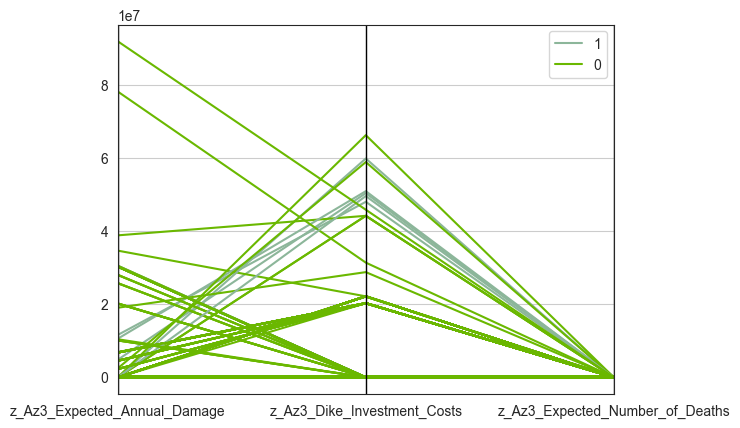

In [166]:
buf = pd.concat(archs)

pd.plotting.parallel_coordinates(buf, class_column='z_0_RfR_0', cols=['z_Az3_Expected_Annual_Damage', 'z_Az3_Dike_Investment_Costs', 'z_Az3_Expected_Number_of_Deaths'])

buf = buf.loc[(buf['z_Az3_Expected_Annual_Damage'] != 0)\
              & (buf['z_Az3_Dike_Investment_Costs'] != 0)\
              & (buf['z_Az3_Expected_Number_of_Deaths'] != 0), :]
# 
# # buf = buf.loc[(buf['z_Az3_Expected_Annual_Damage'] == 0)\
# #               & (buf['z_Az3_Dike_Investment_Costs'] == 0)\
# #               & (buf['z_Az3_Expected_Number_of_Deaths'] == 0), :]
# 
buf = buf.value_counts().reset_index().drop(columns='count')
# 
# buf = epsilon_nondominated([buf], [0.0025] * len(ooi), to_problem(dummy_model, searchover="levers"))
# buf_min = buf.quantile(q=0.5)
# buf_min = buf.min()
# # # # 
# buf = buf.loc[(buf['z_Az3_Expected_Annual_Damage'] == buf_min['z_Az3_Expected_Annual_Damage'])\
#               | (buf['z_Az3_Expected_Number_of_Deaths'] == buf_min['z_Az3_Expected_Number_of_Deaths'])
#               | (buf['z_Az3_Expected_Number_of_Deaths'] == buf_min['z_Az3_Expected_Number_of_Deaths']), :]




buf
# # 
# # 'z_Az3_Expected_Annual_Damage',
# #        'z_Az3_Dike_Investment_Costs', 'z_Az3_Expected_Number_of_Deaths']

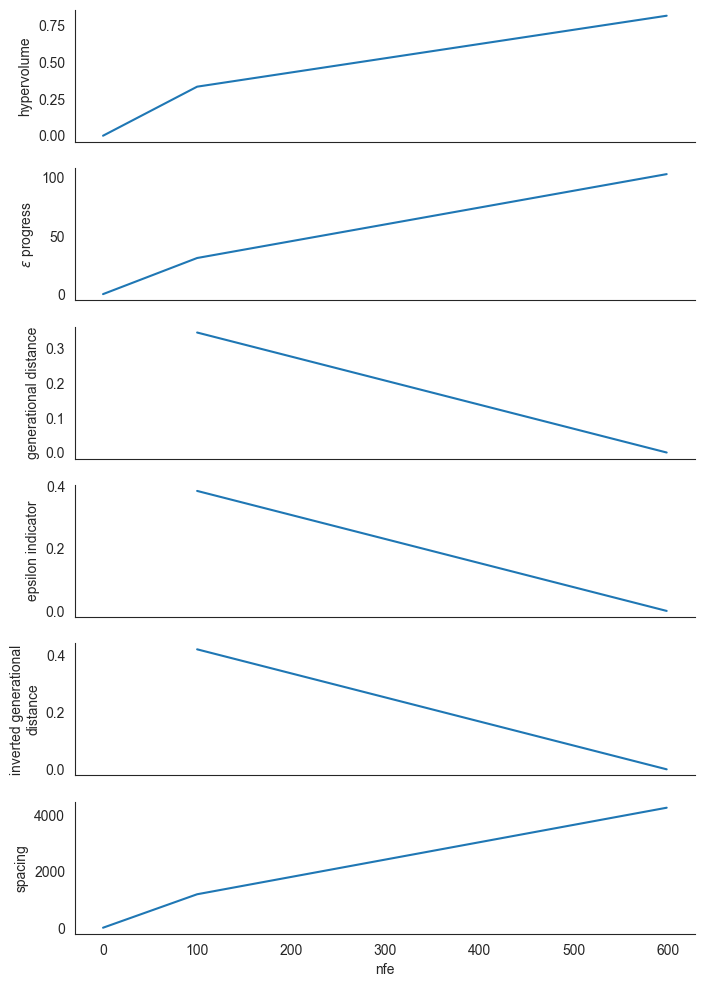

In [20]:
archives = ArchiveLogger.load_archives(os.path.join('experiment', 'optimize_test.tar.gz'))
for key in archives.keys():
    archives[key] = archives[key].drop(columns='Unnamed: 0')
    archives[key] = archives[key].rename(columns={ x: 'z_' + "_".join(x.split(" ")) for x in archives[key].columns}) 
    archives[key] = archives[key].rename(columns={ x: x.replace('.', 'z') for x in archives[key].columns})
# reference_set = epsilon_nondominated(archives, [0.025] * len(ooi), to_problem(dummy_model, searchover="levers"))
reference_set = archives[max(archives.keys())]
# reference_set = archives[100]
metrics = calculate_metrics(archives, reference_set)
plot_metrics(metrics, convergence)

plt.show()

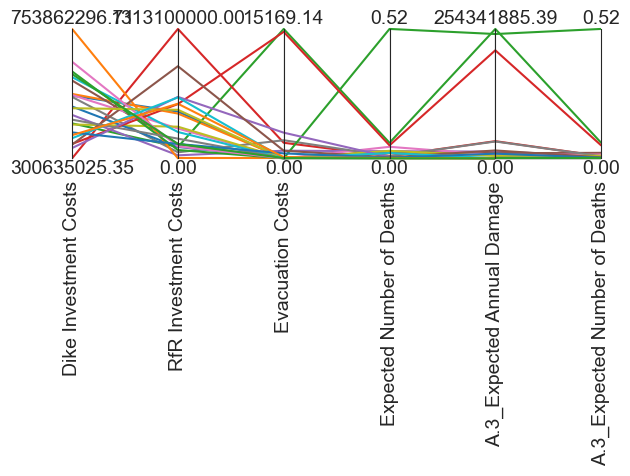

In [22]:
limits = parcoords.get_limits(results[[o.name for o in buf_model.outcomes]])
axes = parcoords.ParallelAxes(limits)
axes.plot(results[[o.name for o in buf_model.outcomes]])

# we invert this axis so direction of desirability is the same 
# axes.invert_axis('max_P')
# axes.invert_axis('max_P')
# axes.invert_axis('max_P')
plt.show()

In [23]:
results

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths,A.3_Expected Annual Damage,A.3_Expected Number of Deaths
0,0,0,0,0,1,0,0,0,0,0,...,5,5,9,8,5.202663e+08,4.739000e+08,0.000000,0.000000,0.000000e+00,0.000000
1,1,0,0,0,0,1,1,0,0,0,...,9,4,5,4,5.262535e+08,4.543000e+08,0.000000,0.020562,9.296538e+06,0.020562
2,0,1,0,0,0,0,0,0,1,0,...,2,0,6,3,4.231108e+08,1.153000e+08,15169.138575,0.062578,2.543419e+08,0.062578
3,0,1,0,0,1,0,0,0,0,1,...,6,5,0,8,3.006350e+08,1.313100e+09,1823.253963,0.008904,3.374141e+07,0.008904
4,0,0,0,0,0,0,0,0,1,0,...,10,1,4,5,4.526710e+08,3.070000e+07,895.496361,0.028541,1.327450e+07,0.010592
5,1,0,0,0,0,0,1,0,1,0,...,9,3,5,6,5.731455e+08,1.460000e+08,0.000000,0.026757,1.006806e+07,0.022073
6,0,1,0,1,0,0,0,0,0,0,...,6,1,2,6,5.223684e+08,3.024000e+08,0.000000,0.046316,6.759554e+06,0.015197
7,0,0,0,0,0,0,1,1,0,0,...,2,7,6,0,5.157330e+08,6.140000e+07,2120.644622,0.008605,3.311344e+07,0.008605
8,0,1,1,0,0,0,0,0,1,1,...,5,0,5,10,4.191538e+08,3.211000e+08,0.000000,0.030161,4.648269e+06,0.010281
9,0,0,1,0,0,0,1,1,0,0,...,5,6,3,5,5.850063e+08,2.672000e+08,0.000000,0.000000,0.000000e+00,0.000000


In [15]:
archives = ArchiveLogger.load_archives(os.path.join('mordm', 'results_optimize_box_1_max_0.tar.gz'))
for key in archives.keys():
    archives[key] = archives[key].drop(columns='Unnamed: 0')
    archives[key] = archives[key].rename(columns={ x: 'z_' + "_".join(x.split(" ")) for x in archives[key].columns}) 
    archives[key] = archives[key].rename(columns={ x: x.replace('.', 'z') for x in archives[key].columns})
# reference_set = epsilon_nondominated(archives, [0.025] * len(ooi), to_problem(dummy_model, searchover="levers"))
reference_set = archives[max(archives.keys())]
# reference_set = archives[100]
metrics = calculate_metrics(archives, reference_set)
plot_metrics(metrics)

plt.show()


/var/folders/kh/8ls_kfyd28j3v0nb9fsj54g00000gn/T/ipykernel_87697/1130373596.py:80: SyntaxWarning: invalid escape sequence '\e'
  ax2.set_ylabel("$\epsilon$ progress")


PlatypusError: objective with empty range

In [ ]:
Convergence(metrics, max_nfe=100000)

In [75]:
archives

{0: Empty DataFrame
 Columns: [z_0_RfR_0, z_0_RfR_1, z_0_RfR_2, z_1_RfR_0, z_1_RfR_1, z_1_RfR_2, z_2_RfR_0, z_2_RfR_1, z_2_RfR_2, z_3_RfR_0, z_3_RfR_1, z_3_RfR_2, z_4_RfR_0, z_4_RfR_1, z_4_RfR_2, z_EWS_DaysToThreat, z_Az1_DikeIncrease_0, z_Az1_DikeIncrease_1, z_Az1_DikeIncrease_2, z_Az2_DikeIncrease_0, z_Az2_DikeIncrease_1, z_Az2_DikeIncrease_2, z_Az3_DikeIncrease_0, z_Az3_DikeIncrease_1, z_Az3_DikeIncrease_2, z_Az4_DikeIncrease_0, z_Az4_DikeIncrease_1, z_Az4_DikeIncrease_2, z_Az5_DikeIncrease_0, z_Az5_DikeIncrease_1, z_Az5_DikeIncrease_2, z_Az3_Expected_Annual_Damage, z_Az3_Dike_Investment_Costs, z_Az3_Expected_Number_of_Deaths]
 Index: []
 
 [0 rows x 34 columns],
 100:    z_0_RfR_0  z_0_RfR_1  z_0_RfR_2  z_1_RfR_0  z_1_RfR_1  z_1_RfR_2  \
 0          1          1          1          1          1          0   
 1          1          1          1          0          0          0   
 2          0          0          1          1          0          0   
 3          1          1        

In [53]:
for key in archives.keys():
    print(archives[key][ooi_dr3])

Empty DataFrame
Columns: [A.3_Expected Annual Damage, A.3_Expected Number of Deaths, A.3_Dike Investment Costs]
Index: []
   A.3_Expected Annual Damage  A.3_Expected Number of Deaths  \
0                1.161100e+07                       0.008995   
1                4.819333e+06                       0.001244   
2                3.467844e+07                       0.008934   
3                0.000000e+00                       0.000000   

   A.3_Dike Investment Costs  
0               4.804784e+07  
1               5.040648e+07  
2               2.216782e+07  
3               5.990344e+07  
   A.3_Expected Annual Damage  A.3_Expected Number of Deaths  \
0                         0.0                            0.0   

   A.3_Dike Investment Costs  
0                        0.0  
   A.3_Expected Annual Damage  A.3_Expected Number of Deaths  \
0                         0.0                            0.0   

   A.3_Dike Investment Costs  
0                        0.0  
   A.3_Expected Annu

In [79]:
reference_set = archives[100]

In [80]:
reference_set.problem

AttributeError: 'DataFrame' object has no attribute 'problem'

In [160]:
# To get the nfe graph, run this cell
archives = ArchiveLogger.load_archives(os.path.join('experiment', 'optimize_test.tar.gz'))
for key in archives.keys():
    archives[key] = archives[key].drop(columns='Unnamed: 0')
    archives[key] = archives[key].rename(columns={ x: 'z_' + "_".join(x.split(" ")) for x in archives[key].columns}) 
    archives[key] = archives[key].rename(columns={ x: x.replace('.', 'z') for x in archives[key].columns})
reference_set = archives[max(archives.keys())] # this is the final archive

metrics = calculate_metrics(archives, reference_set)
plot_metrics(metrics, convergence)

plt.show()

TypeError: plot_metrics() takes 1 positional argument but 2 were given